# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1_wisig-metehan",
    "device": "cuda",
    "lr": 0.001,
    "seed": 1337,
    "dataset_seed": 1337,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 19,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": 100,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                0,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                8,
                9,
                10,
                11,
                12,
                13,
                14,
                15,
                16,
                17,
                18,
            ],
            "domains": [0, 1, 2],
            "num_examples_per_domain_per_label": 100,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/metehan.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "Metehan_",
        },
    ],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'Wisig_2', 'Wisig_4', 'Wisig_3', 'Wisig_1'}


{'Metehan_2', 'Metehan_1', 'Metehan_0'}


tensor([[[ 0.0581,  0.0523, -0.1186,  ..., -0.1696,  0.0436,  0.3136],
         [ 0.0399, -0.0075, -0.4210,  ...,  0.5658,  0.1140, -0.2248]],

        [[ 1.0695, -0.1871, -1.2296,  ...,  0.6706, -0.2726, -1.1197],
         [ 0.3552,  0.9957, -0.0448,  ...,  0.5670,  0.8557, -0.3234]],

        [[ 0.0346, -0.1704, -0.2148,  ...,  0.1403,  0.0305,  0.4276],
         [-0.0725,  0.0366, -0.7328,  ...,  0.1582, -0.2653, -0.6542]],

        ...,

        [[-0.1934,  0.3953,  0.0171,  ..., -0.3248,  0.0160, -0.2137],
         [-0.0299, -0.0085,  0.6956,  ...,  0.5385,  0.8121,  1.0749]],

        [[ 0.1379, -0.1584, -0.7434,  ..., -0.4956, -0.7908, -1.0483],
         [-0.1853,  0.4568, -0.2263,  ..., -0.3448, -0.1875, -0.3534]],

        [[-0.2580, -1.0624, -1.2842,  ...,  0.1603, -0.5715, -0.5191],
         [ 1.0019,  0.7268,  0.0212,  ...,  0.9193,  1.1430,  0.5937]]])


In [21]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 1128], examples_per_second: 233.3738, train_label_loss: 2.9111, 


epoch: 1, [batch: 113 / 1128], examples_per_second: 3214.5801, train_label_loss: 0.3198, 


epoch: 1, [batch: 226 / 1128], examples_per_second: 3252.7382, train_label_loss: 0.6951, 


epoch: 1, [batch: 339 / 1128], examples_per_second: 3256.2539, train_label_loss: 0.5229, 


epoch: 1, [batch: 451 / 1128], examples_per_second: 3251.3679, train_label_loss: 0.1969, 


epoch: 1, [batch: 564 / 1128], examples_per_second: 3248.9064, train_label_loss: 0.2664, 


epoch: 1, [batch: 677 / 1128], examples_per_second: 3240.5003, train_label_loss: 0.0778, 


epoch: 1, [batch: 789 / 1128], examples_per_second: 3230.7866, train_label_loss: 0.1576, 


epoch: 1, [batch: 902 / 1128], examples_per_second: 3246.5079, train_label_loss: 0.6934, 


epoch: 1, [batch: 1015 / 1128], examples_per_second: 3249.1772, train_label_loss: 0.1314, 


epoch: 1, source_val_acc_label: 0.9263, target_val_acc_label: 0.3363, source_val_label_loss: 0.3028, target_val_label_loss: 2.6964, 


New best


epoch: 2, [batch: 1 / 1128], examples_per_second: 32.9783, train_label_loss: 0.0626, 


epoch: 2, [batch: 113 / 1128], examples_per_second: 3258.8404, train_label_loss: 0.4342, 


epoch: 2, [batch: 226 / 1128], examples_per_second: 3287.6445, train_label_loss: 0.5278, 


epoch: 2, [batch: 339 / 1128], examples_per_second: 3290.3130, train_label_loss: 0.0874, 


epoch: 2, [batch: 451 / 1128], examples_per_second: 3277.0659, train_label_loss: 0.0484, 


epoch: 2, [batch: 564 / 1128], examples_per_second: 3259.4130, train_label_loss: 0.0495, 


epoch: 2, [batch: 677 / 1128], examples_per_second: 3258.2136, train_label_loss: 0.0666, 


epoch: 2, [batch: 789 / 1128], examples_per_second: 3243.2132, train_label_loss: 0.3850, 


epoch: 2, [batch: 902 / 1128], examples_per_second: 3259.0239, train_label_loss: 0.0560, 


epoch: 2, [batch: 1015 / 1128], examples_per_second: 3257.8659, train_label_loss: 0.0304, 


epoch: 2, source_val_acc_label: 0.9447, target_val_acc_label: 0.3304, source_val_label_loss: 0.2453, target_val_label_loss: 2.6704, 


New best


epoch: 3, [batch: 1 / 1131], examples_per_second: 33.1289, train_label_loss: 0.1596, 


epoch: 3, [batch: 114 / 1131], examples_per_second: 3279.1936, train_label_loss: 0.1010, 


epoch: 3, [batch: 227 / 1131], examples_per_second: 3310.0569, train_label_loss: 0.0360, 


epoch: 3, [batch: 340 / 1131], examples_per_second: 3304.3823, train_label_loss: 0.1892, 


epoch: 3, [batch: 453 / 1131], examples_per_second: 3273.8318, train_label_loss: 0.0730, 


epoch: 3, [batch: 566 / 1131], examples_per_second: 3282.7167, train_label_loss: 0.0490, 


epoch: 3, [batch: 679 / 1131], examples_per_second: 3287.3462, train_label_loss: 0.2477, 


epoch: 3, [batch: 792 / 1131], examples_per_second: 3276.6347, train_label_loss: 0.1488, 


epoch: 3, [batch: 905 / 1131], examples_per_second: 3292.8600, train_label_loss: 0.4718, 


epoch: 3, [batch: 1018 / 1131], examples_per_second: 3258.1912, train_label_loss: 0.0058, 


epoch: 3, source_val_acc_label: 0.9488, target_val_acc_label: 0.3377, source_val_label_loss: 0.2207, target_val_label_loss: 2.6137, 


New best


epoch: 4, [batch: 1 / 1128], examples_per_second: 32.7904, train_label_loss: 0.0068, 


epoch: 4, [batch: 113 / 1128], examples_per_second: 3267.0599, train_label_loss: 0.1326, 


epoch: 4, [batch: 226 / 1128], examples_per_second: 3303.6831, train_label_loss: 0.0408, 


epoch: 4, [batch: 339 / 1128], examples_per_second: 3279.1951, train_label_loss: 0.3011, 


epoch: 4, [batch: 451 / 1128], examples_per_second: 3294.8730, train_label_loss: 0.3407, 


epoch: 4, [batch: 564 / 1128], examples_per_second: 3298.5391, train_label_loss: 0.1824, 


epoch: 4, [batch: 677 / 1128], examples_per_second: 3287.3181, train_label_loss: 0.1892, 


epoch: 4, [batch: 789 / 1128], examples_per_second: 3280.5968, train_label_loss: 0.0033, 


epoch: 4, [batch: 902 / 1128], examples_per_second: 3299.2417, train_label_loss: 0.0698, 


epoch: 4, [batch: 1015 / 1128], examples_per_second: 3309.7783, train_label_loss: 0.1980, 


epoch: 4, source_val_acc_label: 0.9535, target_val_acc_label: 0.3553, source_val_label_loss: 0.2282, target_val_label_loss: 2.5034, 


New best


epoch: 5, [batch: 1 / 1128], examples_per_second: 33.2441, train_label_loss: 0.0208, 


epoch: 5, [batch: 113 / 1128], examples_per_second: 3218.8286, train_label_loss: 0.0976, 


epoch: 5, [batch: 226 / 1128], examples_per_second: 3260.7988, train_label_loss: 0.1498, 


epoch: 5, [batch: 339 / 1128], examples_per_second: 3304.4526, train_label_loss: 0.0452, 


epoch: 5, [batch: 451 / 1128], examples_per_second: 3246.4045, train_label_loss: 0.1543, 


epoch: 5, [batch: 564 / 1128], examples_per_second: 3290.9363, train_label_loss: 0.0239, 


epoch: 5, [batch: 677 / 1128], examples_per_second: 3255.3656, train_label_loss: 0.2278, 


epoch: 5, [batch: 789 / 1128], examples_per_second: 3254.7778, train_label_loss: 0.0534, 


epoch: 5, [batch: 902 / 1128], examples_per_second: 3254.0067, train_label_loss: 0.0857, 


epoch: 5, [batch: 1015 / 1128], examples_per_second: 3271.3721, train_label_loss: 0.2996, 


epoch: 5, source_val_acc_label: 0.9498, target_val_acc_label: 0.3713, source_val_label_loss: 0.2276, target_val_label_loss: 2.5221, 


epoch: 6, [batch: 1 / 1128], examples_per_second: 33.4482, train_label_loss: 0.2855, 


epoch: 6, [batch: 113 / 1128], examples_per_second: 3273.5078, train_label_loss: 0.2736, 


epoch: 6, [batch: 226 / 1128], examples_per_second: 3288.1879, train_label_loss: 0.2449, 


epoch: 6, [batch: 339 / 1128], examples_per_second: 3299.0046, train_label_loss: 0.1973, 


epoch: 6, [batch: 451 / 1128], examples_per_second: 3281.2550, train_label_loss: 0.0375, 


epoch: 6, [batch: 564 / 1128], examples_per_second: 3295.6305, train_label_loss: 0.0343, 


epoch: 6, [batch: 677 / 1128], examples_per_second: 3289.9365, train_label_loss: 0.1049, 


epoch: 6, [batch: 789 / 1128], examples_per_second: 3288.0132, train_label_loss: 0.0618, 


epoch: 6, [batch: 902 / 1128], examples_per_second: 3296.6109, train_label_loss: 0.0072, 


epoch: 6, [batch: 1015 / 1128], examples_per_second: 3290.8488, train_label_loss: 0.2214, 


epoch: 6, source_val_acc_label: 0.9525, target_val_acc_label: 0.3436, source_val_label_loss: 0.2310, target_val_label_loss: 2.4984, 


New best


epoch: 7, [batch: 1 / 1129], examples_per_second: 33.0547, train_label_loss: 0.0066, 


epoch: 7, [batch: 113 / 1129], examples_per_second: 3247.5598, train_label_loss: 0.0021, 


epoch: 7, [batch: 226 / 1129], examples_per_second: 3256.4790, train_label_loss: 0.0135, 


epoch: 7, [batch: 339 / 1129], examples_per_second: 3271.5385, train_label_loss: 0.1313, 


epoch: 7, [batch: 452 / 1129], examples_per_second: 3246.0016, train_label_loss: 0.0181, 


epoch: 7, [batch: 565 / 1129], examples_per_second: 3295.8320, train_label_loss: 0.0767, 


epoch: 7, [batch: 677 / 1129], examples_per_second: 3286.9113, train_label_loss: 0.0023, 


epoch: 7, [batch: 790 / 1129], examples_per_second: 3302.7447, train_label_loss: 0.1338, 


epoch: 7, [batch: 903 / 1129], examples_per_second: 3313.6159, train_label_loss: 0.1295, 


epoch: 7, [batch: 1016 / 1129], examples_per_second: 3313.7612, train_label_loss: 0.0191, 


epoch: 7, source_val_acc_label: 0.9546, target_val_acc_label: 0.3480, source_val_label_loss: 0.2351, target_val_label_loss: 2.4614, 


New best


epoch: 8, [batch: 1 / 1127], examples_per_second: 32.8411, train_label_loss: 0.1206, 


epoch: 8, [batch: 113 / 1127], examples_per_second: 3293.3443, train_label_loss: 0.0025, 


epoch: 8, [batch: 226 / 1127], examples_per_second: 3305.9991, train_label_loss: 0.0355, 


epoch: 8, [batch: 338 / 1127], examples_per_second: 3307.8406, train_label_loss: 0.0067, 


epoch: 8, [batch: 451 / 1127], examples_per_second: 3289.7824, train_label_loss: 0.0188, 


epoch: 8, [batch: 564 / 1127], examples_per_second: 3288.1199, train_label_loss: 0.0684, 


epoch: 8, [batch: 676 / 1127], examples_per_second: 3301.6924, train_label_loss: 0.0053, 


epoch: 8, [batch: 789 / 1127], examples_per_second: 3269.6484, train_label_loss: 0.0379, 


epoch: 8, [batch: 901 / 1127], examples_per_second: 3281.1698, train_label_loss: 0.0112, 


epoch: 8, [batch: 1014 / 1127], examples_per_second: 3289.5252, train_label_loss: 0.2924, 


epoch: 8, source_val_acc_label: 0.9610, target_val_acc_label: 0.4678, source_val_label_loss: 0.2191, target_val_label_loss: 2.0506, 


New best


epoch: 9, [batch: 1 / 1127], examples_per_second: 32.9599, train_label_loss: 0.0012, 


epoch: 9, [batch: 113 / 1127], examples_per_second: 3272.0325, train_label_loss: 0.0054, 


epoch: 9, [batch: 226 / 1127], examples_per_second: 3313.1892, train_label_loss: 0.0171, 


epoch: 9, [batch: 338 / 1127], examples_per_second: 3307.4692, train_label_loss: 0.0026, 


epoch: 9, [batch: 451 / 1127], examples_per_second: 3290.0882, train_label_loss: 0.0421, 


epoch: 9, [batch: 564 / 1127], examples_per_second: 3301.2862, train_label_loss: 0.0447, 


epoch: 9, [batch: 676 / 1127], examples_per_second: 3282.9208, train_label_loss: 0.0014, 


epoch: 9, [batch: 789 / 1127], examples_per_second: 3290.7136, train_label_loss: 0.2892, 


epoch: 9, [batch: 901 / 1127], examples_per_second: 3295.2465, train_label_loss: 0.0379, 


epoch: 9, [batch: 1014 / 1127], examples_per_second: 3311.9110, train_label_loss: 0.0014, 


epoch: 9, source_val_acc_label: 0.9592, target_val_acc_label: 0.3801, source_val_label_loss: 0.2361, target_val_label_loss: 2.3310, 


epoch: 10, [batch: 1 / 1129], examples_per_second: 33.4884, train_label_loss: 0.0406, 


epoch: 10, [batch: 113 / 1129], examples_per_second: 3281.5202, train_label_loss: 0.0026, 


epoch: 10, [batch: 226 / 1129], examples_per_second: 3293.1004, train_label_loss: 0.0617, 


epoch: 10, [batch: 339 / 1129], examples_per_second: 3296.8984, train_label_loss: 0.0148, 


epoch: 10, [batch: 452 / 1129], examples_per_second: 3274.6864, train_label_loss: 0.0001, 


epoch: 10, [batch: 565 / 1129], examples_per_second: 3282.9812, train_label_loss: 0.2201, 


epoch: 10, [batch: 677 / 1129], examples_per_second: 3294.0695, train_label_loss: 0.3605, 


epoch: 10, [batch: 790 / 1129], examples_per_second: 3279.6890, train_label_loss: 0.0226, 


epoch: 10, [batch: 903 / 1129], examples_per_second: 3276.5489, train_label_loss: 0.2894, 


epoch: 10, [batch: 1016 / 1129], examples_per_second: 3286.4257, train_label_loss: 0.1228, 


epoch: 10, source_val_acc_label: 0.9582, target_val_acc_label: 0.3860, source_val_label_loss: 0.2535, target_val_label_loss: 2.3150, 


epoch: 11, [batch: 1 / 1130], examples_per_second: 33.4216, train_label_loss: 0.0003, 


epoch: 11, [batch: 113 / 1130], examples_per_second: 3276.8197, train_label_loss: 0.0399, 


epoch: 11, [batch: 226 / 1130], examples_per_second: 3279.9403, train_label_loss: 0.0020, 


epoch: 11, [batch: 339 / 1130], examples_per_second: 3286.5781, train_label_loss: 0.4435, 


epoch: 11, [batch: 452 / 1130], examples_per_second: 3272.4073, train_label_loss: 0.0024, 


epoch: 11, [batch: 565 / 1130], examples_per_second: 3293.5022, train_label_loss: 0.2031, 


epoch: 11, [batch: 678 / 1130], examples_per_second: 3299.4010, train_label_loss: 0.1246, 


epoch: 11, [batch: 791 / 1130], examples_per_second: 3280.4895, train_label_loss: 0.3919, 


epoch: 11, [batch: 904 / 1130], examples_per_second: 3260.5433, train_label_loss: 0.1014, 


epoch: 11, [batch: 1017 / 1130], examples_per_second: 3278.8555, train_label_loss: 0.2027, 


epoch: 11, source_val_acc_label: 0.9609, target_val_acc_label: 0.3684, source_val_label_loss: 0.2683, target_val_label_loss: 2.1551, 


epoch: 12, [batch: 1 / 1131], examples_per_second: 33.3214, train_label_loss: 0.0119, 


epoch: 12, [batch: 114 / 1131], examples_per_second: 3252.2587, train_label_loss: 0.1231, 


epoch: 12, [batch: 227 / 1131], examples_per_second: 3257.9894, train_label_loss: 0.0671, 


epoch: 12, [batch: 340 / 1131], examples_per_second: 3264.3326, train_label_loss: 0.0448, 


epoch: 12, [batch: 453 / 1131], examples_per_second: 3291.8212, train_label_loss: 0.0034, 


epoch: 12, [batch: 566 / 1131], examples_per_second: 3293.4176, train_label_loss: 0.0267, 


epoch: 12, [batch: 679 / 1131], examples_per_second: 3282.5544, train_label_loss: 0.0232, 


epoch: 12, [batch: 792 / 1131], examples_per_second: 3276.7392, train_label_loss: 0.0600, 


epoch: 12, [batch: 905 / 1131], examples_per_second: 3291.8600, train_label_loss: 0.0024, 


epoch: 12, [batch: 1018 / 1131], examples_per_second: 3287.4083, train_label_loss: 0.0073, 


epoch: 12, source_val_acc_label: 0.9607, target_val_acc_label: 0.3173, source_val_label_loss: 0.2652, target_val_label_loss: 2.3244, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

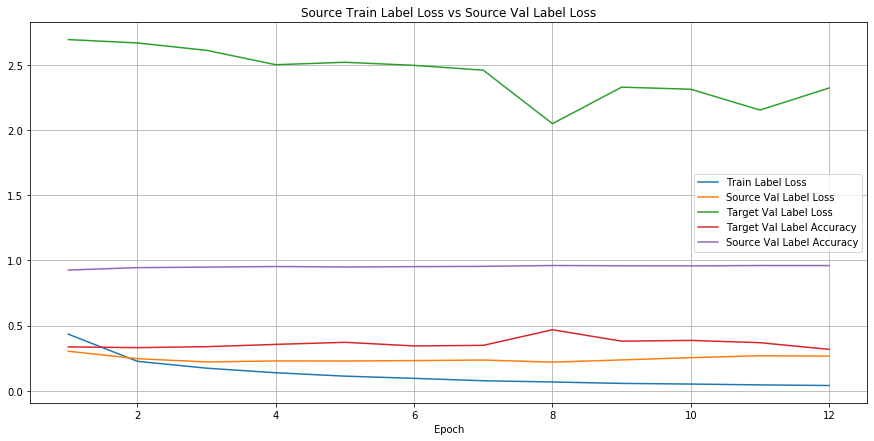

In [25]:
ax = get_loss_curve(experiment)
plt.show()

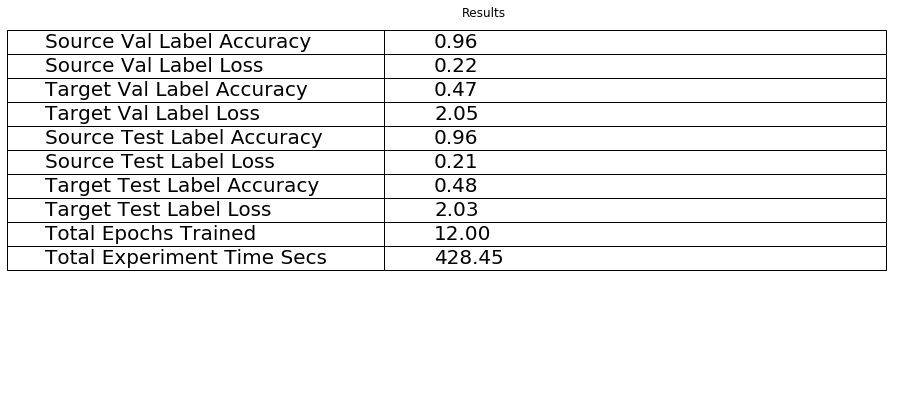

In [26]:
get_results_table(experiment)

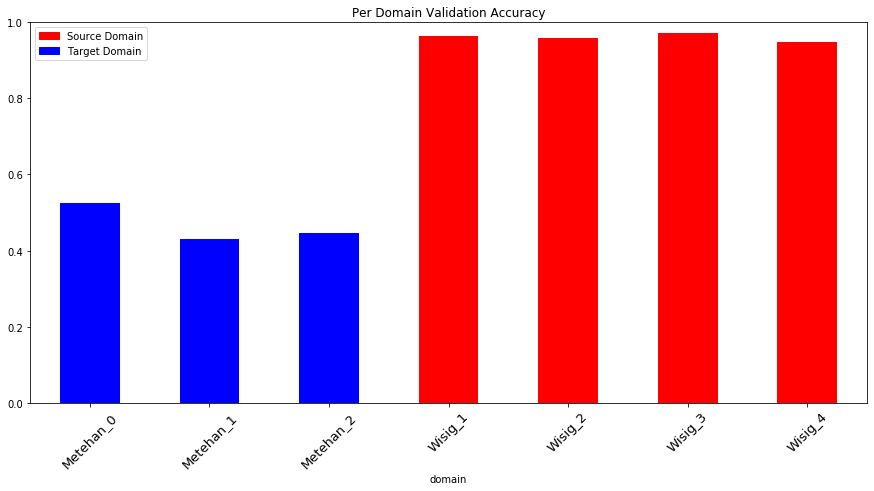

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9623355263157894 Target Test Label Accuracy: 0.48391812865497075
Source Val Label Accuracy: 0.9610197368421053 Target Val Label Accuracy: 0.4678362573099415


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1_wisig-metehan", "parameters": {"experiment_name": "tl_1_wisig-metehan", "device": "cuda", "lr": 0.001, "seed": 1337, "dataset_seed": 1337, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 25